In [1]:
import copy
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights
import lightning as pl
import torchmetrics
import comet_ml
import os
from lightning.pytorch import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from comet_ml import Experiment
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
from comet_ml import start
from comet_ml.integration.pytorch import log_model
from utils import key


experiment = start(
  api_key=key,
  project_name="general",
  workspace="robb666"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/robb666/general/caca0e44ec3d4b6ba0a5e911381877f0



In [3]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


In [4]:
class Dataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes_to_ignore = ["del", "nothing", "space"]
        self.images = []
        self.labels = []
        
        if dataset_type == "train":
            for class_name in os.listdir(root_dir):
                if class_name not in self.classes_to_ignore:
                    class_path = os.path.join(root_dir, class_name)
                    if os.path.isdir(class_path):
                        for img_name in os.listdir(class_path):
                            if img_name.endswith(('.jpg', '.png')):
                                self.images.append(os.path.join(class_path, img_name))
                                self.labels.append(class_name)
        else:
            for img_name in os.listdir(root_dir):
                if img_name.endswith('_test.jpg'):
                    class_name = img_name.replace('_test.jpg', '')
                    if class_name not in self.classes_to_ignore:
                        self.images.append(os.path.join(root_dir, img_name))
                        self.labels.append(class_name)
        
        self.classes = sorted(list(set(self.labels))) 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}
        
        print(f"Dataset type: {dataset_type}")
        print(f"Total images loaded: {len(self.images)}")
        print(f"Total labels loaded: {len(self.labels)}")
        print(f"Classes: {self.classes}")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.class_to_idx[self.labels[index]]
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label

In [5]:

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
from torch.utils.data import random_split

full_dataset = Dataset(root_dir='./dataset/asl_alphabet_train/', dataset_type='train', transform=train_transform)


total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, temp_dataset = random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])


class SubsetWithClasses(Dataset):
    def __init__(self, subset, classes):
        self.subset = subset
        self.classes = classes
        
    def __getitem__(self, idx):
        return self.subset[idx]
    
    def __len__(self):
        return len(self.subset)


train_dataset = SubsetWithClasses(train_dataset, full_dataset.classes)
val_dataset = SubsetWithClasses(val_dataset, full_dataset.classes)
test_dataset = SubsetWithClasses(test_dataset, full_dataset.classes)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


num_classes = len(train_dataset.classes)



print(f"Full dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


weights = ResNet34_Weights.DEFAULT
resnet_model = resnet34(weights=weights).to(device)

for param in resnet_model.parameters():
    param.requires_grad = False

num_inputs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_inputs, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, num_classes)
)

Dataset type: train
Total images loaded: 78000
Total labels loaded: 78000
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Full dataset size: 78000
Training set size: 54600
Validation set size: 11700
Test set size: 11700


In [7]:
# holdout_test_dataset = Dataset(root_dir='./dataset/asl_alphabet_test/', dataset_type='test', transform=transform)

In [8]:
weights = ResNet34_Weights.DEFAULT
resnet_model = resnet34(weights=weights).to(device)

# Freeze the convolutional layers
for param in resnet_model.parameters():
    param.requires_grad = False

# Change classifier (fc) to satisfy application
num_classes = len(train_dataset.classes)
num_inputs = resnet_model.fc.in_features  # 512 for ResNet34 vs 2048 for ResNet50

resnet_model.fc = nn.Sequential(
    nn.Linear(num_inputs, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, num_classes)
)

In [9]:
total_params = sum(p.numel() for p in resnet_model.parameters())
trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in resnet_model.parameters() if not p.requires_grad)

print(f"All parameters: {total_params}")
print(f"Frozen parameters: {frozen_params}")
print(f"Trainable parameters: {trainable_params}")


All parameters: 21422682
Frozen parameters: 21284672
Trainable parameters: 138010


In [10]:
experiment.set_name("DLF-sign_letters_classification2")


def to_numpy(x):
    return x.detach().numpy()


def update_gradient_map(model, gradmap):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s/%s.%s" % ("gradient", name, "weight")
        bname = "%s/%s.%s" % ("gradient", name, "bias")

        gradmap.setdefault(wname, 0)
        gradmap.setdefault(bname, 0)

        gradmap[wname] += layer.weight.grad
        gradmap[bname] += layer.bias.grad

    return gradmap


def log_gradients(gradmap, step):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(to_numpy(v), name=k, step=step)


def log_weights(model, step):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s.%s" % (name, "weight")
        bname = "%s.%s" % (name, "bias")

        experiment.log_histogram_3d(to_numpy(layer.weight), name=wname, step=step)
        experiment.log_histogram_3d(to_numpy(layer.bias), name=bname, step=step)

In [11]:
learning_rate = 0.001
batch_size = 64
num_epochs = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=learning_rate,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

hyper_params = {
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay
}

experiment.log_parameters(hyper_params)

/home/oobx/Desktop/PROJEKTY/SIiUM/env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    best_model = None
    
    train_losses = []
    val_losses = []
    
    model.to(device)
    print("Starting Training")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if isinstance(scheduler, optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                experiment.log_metric("train_loss", loss.item(), step=batch_idx)

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_epoch_loss)
    
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_epoch_loss)
    
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model = copy.deepcopy(model.state_dict())

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)

    
        experiment.log_metric("epoch_train_loss", epoch_loss, step=epoch)
        experiment.log_metric("epoch_train_accuracy", train_accuracy, step=epoch)
        experiment.log_metric("val_loss", val_epoch_loss, step=epoch)
        experiment.log_metric("val_accuracy", val_accuracy, step=epoch)
        experiment.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)


    model.load_state_dict(best_model)
    return train_losses, val_losses


def test_model(device, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    num_classes = len(test_loader.dataset.classes)
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    print("\nPer-class accuracy:")
    class_names = test_loader.dataset.classes
    for i in range(num_classes):
        class_accuracy = 100 * confusion_matrix[i, i] / confusion_matrix[i].sum()
        print(f'Class {class_names[i]}: {class_accuracy:.2f}%')
        experiment.log_metric(f"class_{class_names[i]}_accuracy", class_accuracy)
    
    return test_loss, test_accuracy, confusion_matrix

In [13]:

train_losses, val_losses = train_model(
    device=device,
    model=resnet_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs
)

test_loss, test_accuracy, confusion_matrix = test_model(
    device=device,
    model=resnet_model,
    test_loader=test_dataloader,
    criterion=criterion
)



Starting Training
Epoch: 1, Batch: 0, Loss: 3.3147
Epoch: 1, Batch: 100, Loss: 2.0691
Epoch: 1, Batch: 200, Loss: 1.2593
Epoch: 1, Batch: 300, Loss: 0.9365
Epoch: 1, Batch: 400, Loss: 0.9570
Epoch: 1, Batch: 500, Loss: 0.7007
Epoch: 1, Batch: 600, Loss: 0.5592
Epoch: 1, Batch: 700, Loss: 0.6437
Epoch: 1, Batch: 800, Loss: 0.5059
Epoch [1/30]
Training Loss: 1.1201, Training Accuracy: 66.71%
Validation Loss: 0.3963, Validation Accuracy: 89.30%
------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 0.6961
Epoch: 2, Batch: 100, Loss: 0.4725
Epoch: 2, Batch: 200, Loss: 0.6908
Epoch: 2, Batch: 300, Loss: 0.4133
Epoch: 2, Batch: 400, Loss: 0.7761
Epoch: 2, Batch: 500, Loss: 0.4448
Epoch: 2, Batch: 600, Loss: 0.5318
Epoch: 2, Batch: 700, Loss: 0.4110
Epoch: 2, Batch: 800, Loss: 0.7163
Epoch [2/30]
Training Loss: 0.5323, Training Accuracy: 82.65%
Validation Loss: 0.2623, Validation Accuracy: 92.41%
------------------------------------------------------------
Epoc

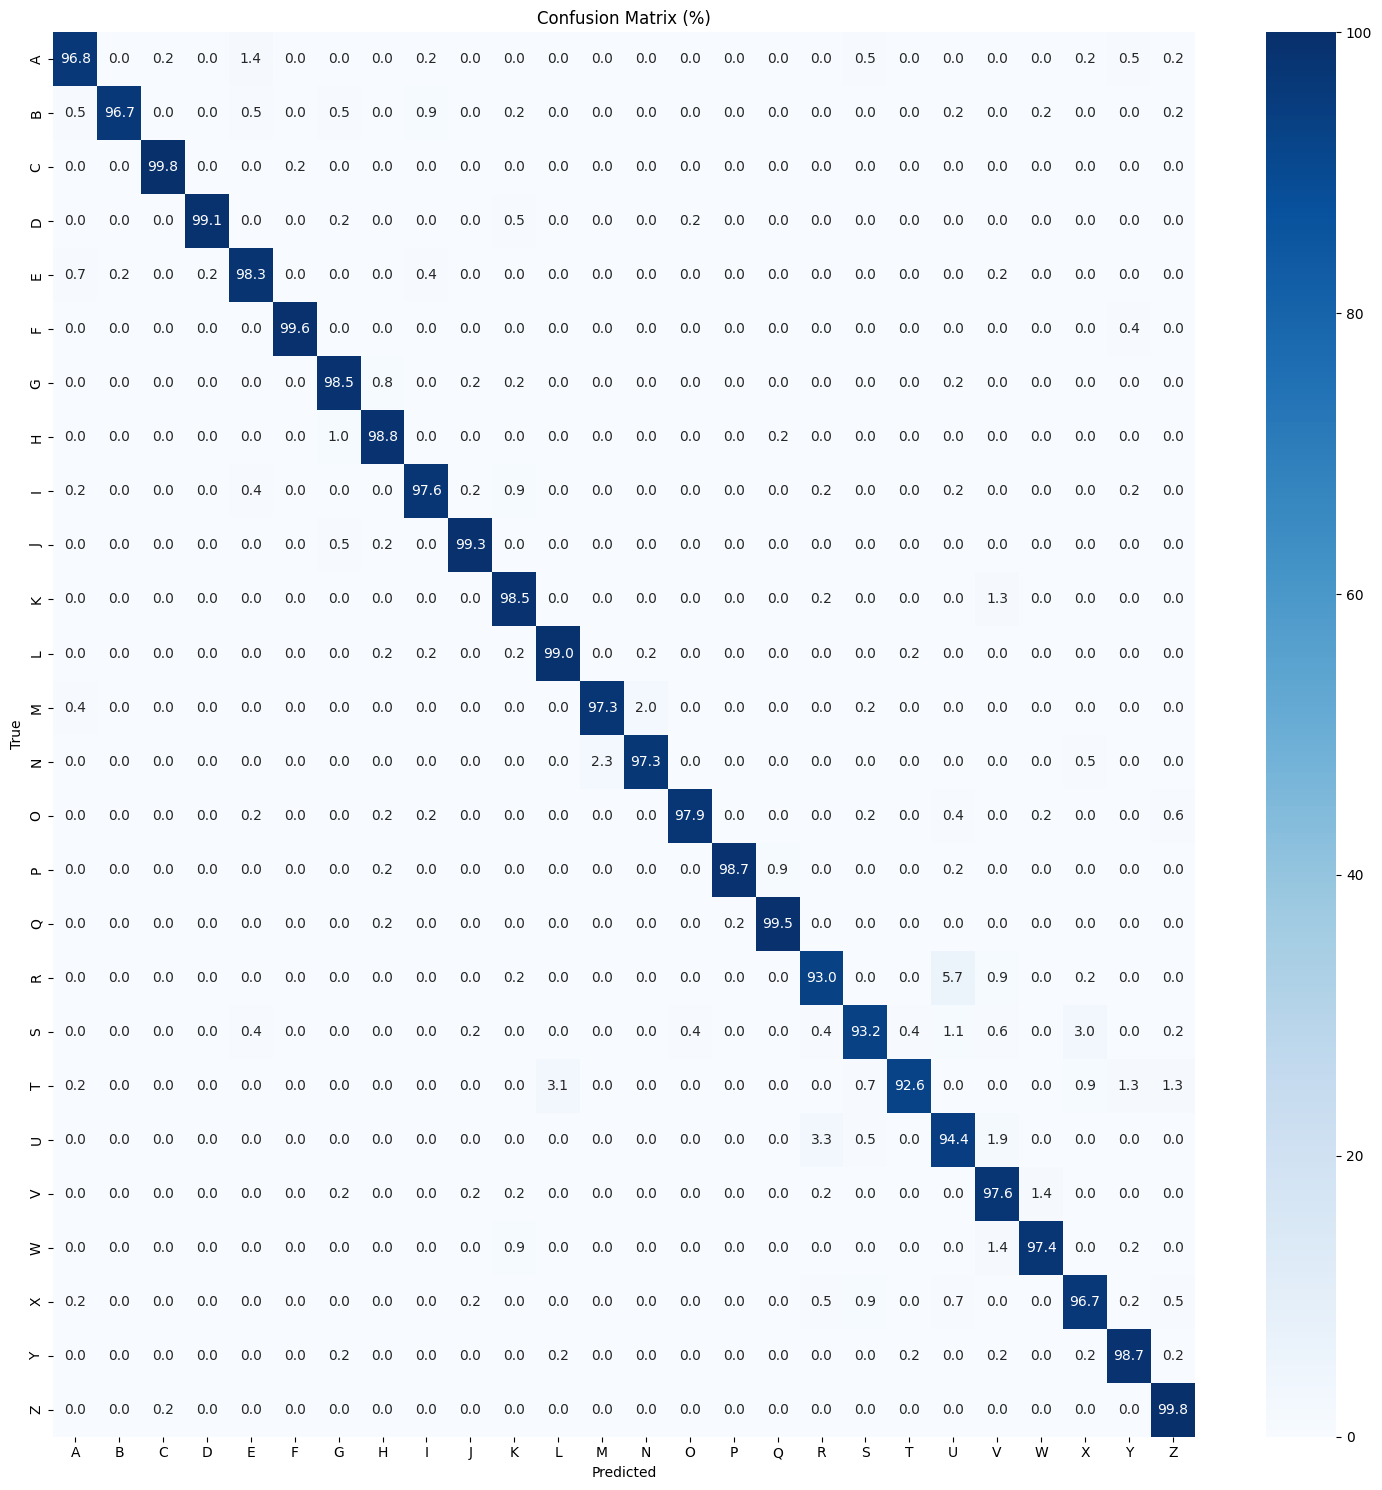


Most confused pairs (True -> Predicted):
R -> U: 5.7%
U -> R: 3.3%
T -> L: 3.1%
S -> X: 3.0%
N -> M: 2.3%
M -> N: 2.0%
U -> V: 1.9%
V -> W: 1.4%
W -> V: 1.4%
A -> E: 1.4%


In [14]:

def plot_confusion_matrix(confusion_matrix, class_names):
    cm_percent = confusion_matrix.numpy()
    cm_percent = cm_percent / cm_percent.sum(axis=1, keepdims=True) * 100

    plt.figure(figsize=(15, 15))

    sns.heatmap(cm_percent, 
                annot=True, 
                fmt='.1f', 
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues',
                vmin=0,
                vmax=100)
    
    plt.title('Confusion Matrix (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    plt.savefig('confusion_matrix.png')
    plt.show()

    print("\nMost confused pairs (True -> Predicted):")
    n_classes = len(class_names)
    confused_pairs = []
    
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm_percent[i, j] > 1:  # More than 1% confusion
                confused_pairs.append((
                    class_names[i], 
                    class_names[j], 
                    cm_percent[i, j]
                ))
    
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    
    for true_class, pred_class, percent in confused_pairs[:10]:
        print(f"{true_class} -> {pred_class}: {percent:.1f}%")

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
plot_confusion_matrix(confusion_matrix, class_names)

In [15]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : DLF-sign_letters_classification2
COMET INFO:     url                   : https://www.comet.com/robb666/general/caca0e44ec3d4b6ba0a5e911381877f0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     class_A_accuracy          : 96.82539367675781
COMET INFO:     class_B_accuracy          : 96.74418640136719
COMET INFO:     class_C_accuracy          : 99.77973937988281
COMET INFO:     class_D_accuracy          : 99.09502410888672
COMET INFO:     class_E_accuracy          : 98.26464080810547
COMET INFO:     class_F_accuracy          : 99.5614013671875
COMET INFO:     class_G_accuracy          : 98.5324935913086
COMET INFO:     class_H_accuracy        

In [40]:
from PIL import Image
from torchvision import transforms

# Funkcja do przewidywania klasy pojedynczego obrazu
def predict_image(image_path, model, device, class_names):
    # Wczytanie i przetworzenie obrazu
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Rozmiar wejścia dla ResNet50
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja ImageNet
    ])

    image = Image.open(image_path).convert('RGB')  # Konwersja na RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class

# Przykład użycia
image_path = "./dataset/asl_alphabet_test/R_test.jpg"
class_names = train_dataset.classes  # Zakładając, że masz listę klas
predicted_class = predict_image(image_path, resnet_model, device, class_names)

print(f"Predicted class: {predicted_class}")

Predicted class: R
